In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

# Fashion MNIST x CNN 流行服飾手繪辨識
* use tensorflow 2.0

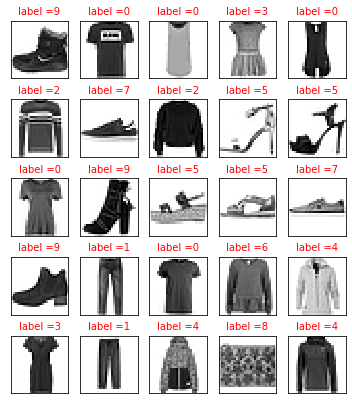

new X_train shape: (60000, 28, 28, 1) , new X_test shape: (10000, 28, 28, 1)
trained model...
Epoch 1/50
1000/1000 - 36s - loss: 1.3216 - accuracy: 0.5143 - val_loss: 0.7327 - val_accuracy: 0.7199
Epoch 2/50
1000/1000 - 35s - loss: 1.0197 - accuracy: 0.6237 - val_loss: 0.6915 - val_accuracy: 0.7351
Epoch 3/50
1000/1000 - 35s - loss: 0.9314 - accuracy: 0.6523 - val_loss: 0.7904 - val_accuracy: 0.6898
Epoch 4/50
1000/1000 - 35s - loss: 0.8840 - accuracy: 0.6682 - val_loss: 0.6607 - val_accuracy: 0.7387
Epoch 5/50
1000/1000 - 36s - loss: 0.8473 - accuracy: 0.6818 - val_loss: 0.6989 - val_accuracy: 0.7401
Epoch 6/50
1000/1000 - 35s - loss: 0.8204 - accuracy: 0.6931 - val_loss: 0.6202 - val_accuracy: 0.7611
Epoch 7/50
1000/1000 - 35s - loss: 0.7987 - accuracy: 0.7025 - val_loss: 0.6131 - val_accuracy: 0.7632
Epoch 8/50
1000/1000 - 36s - loss: 0.7851 - accuracy: 0.7077 - val_loss: 0.5769 - val_accuracy: 0.7824
Epoch 9/50
1000/1000 - 35s - loss: 0.7670 - accuracy: 0.7154 - val_loss: 0.5898 - 

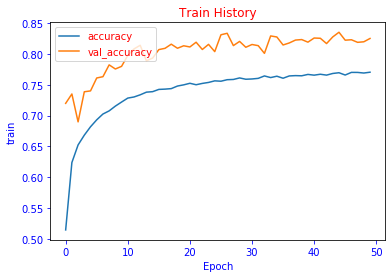

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data, color, io
from skimage.transform import rescale, resize
import tensorflow as tf

# show 25 images
def plot_images_labels_prediction(image, labels, prediction, idx=0, num=10):
    fig = plt.gcf()
    fig.set_size_inches(6, 7)
    if num > 25:
        num = 25
    for i in range(0, num):
        ax = plt.subplot(5, 5, 1+i)
        ax.imshow(image[idx], cmap='binary')
        title = 'label =' + str(labels[idx])
        if len(prediction) > 0:
            title += ", predict=" + str(prediction[idx]) 
        ax.set_title(title, fontsize=10) 
        ax.set_xticks([])
        ax.set_yticks([])        
        idx += 1 
    plt.show()

# load data x Data Preprocessing
def getData():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    # show 25 images
    plot_images_labels_prediction(X_train, y_train, [], 0, num=25)
    
    # normalization
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    
    # channels_last
    img_rows, img_cols = 28, 28
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    print("new X_train shape:", X_train.shape, ", new X_test shape:", X_test.shape)
    
    # one-hot-encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return X_train, y_train, X_test, y_test

def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel('train')
    plt.legend([train, validation], loc='upper left')
    plt.show()

def trainModel(X_train, y_train, X_test, y_test):
    # model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', 
                                     activation='relu', input_shape=(28, 28, 1))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    # loss, optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # data augmentation 
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40, shear_range=0.2, zoom_range=0.3, 
        width_shift_range=0.2, height_shift_range=0.2)
    
    # train
    batch_size = 60
    epochs = 50
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, 
                                  steps_per_epoch=X_train.shape[0]//batch_size, 
                                  validation_data=(X_test, y_test), verbose=2)
    # show train history
    show_train_history(history, 'accuracy', 'val_accuracy')
    
    # save
    model.save('./data/fashion_mnist_model.h5')
    return model

def loadModel():
    model = tf.keras.models.load_model('./data/fashion_mnist_model.h5')
    return model

# Main
X_train, y_train, X_test, y_test = getData()
if (not os.path.exists('./data/fashion_mnist_model.h5')):
    print('trained model...')
    model = trainModel(X_train, y_train, X_test, y_test)
    print(model.summary())
else:
    print('loaded model...')
    model = loadModel()
    print(model.summary())

In [3]:
# read images
IMAGE_DIRECTORY = './data/images'
def ReadImageFile(filename):
    image1 = io.imread(filename, as_gray=True)
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(28, 28, 1)
    return np.abs(1 - X1)
def load_data():
    print("Loading images...")
    X = []     # 存放 每個圖檔矩陣
    y = []     # 存放 檔名
    for dirpath, dirnames, filenames in os.walk(IMAGE_DIRECTORY):
        for filename in [f for f in filenames if f.endswith(".png") or f.endswith(".jpg")]:
            y.append(filename)
            X.append(ReadImageFile(dirpath + '/' + filename))
    return X, y
X, y = load_data()
print('images =', y)

# predict
def predict_model(X):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print('預測結果index =', np.argmax(model.predict(np.array(X)), axis=-1))
    print('預測結果 =', [class_names[i] for i in model.predict_classes(np.array(X))])
if model == None:
    model = loadModel()
    predict_model(X)
else:
    predict_model(X)

Loading images...
images = ['bag1.png', 'tshirt1.png']
預測結果index = [8 0]
預測結果 = ['Bag', 'T-shirt/top']
